# Grade: /100 pts
# Assignment 9: Customer Segmentation with Clustering

In this assignment, you will be solving a traditional problem in quantitative marketing: customer segmentation. Having a properly segmented database is extremely important to define marketing campaigns, as it allows companies to define value-centric actions targeted towards customers of different profiles. In this ocassion you are going to analyze customers of an automobile company.

Assume you are the owner of a consulting company that is in charge of this project. In this assignment you are going to conduct 2 different strategies for segmentating the potential customers.

The information is provided in the document `DATA.csv` which has the following columns:

- **ID:** Customer identifier (it does not have prediction power).
- **Gender:** Gender of a customer.
- **Ever_Married**: Potential customer's marrige status.
- **Age**: Potential customer's age.
- **Graduated:** Education status of the customer.
- **Profession:** Type of customer's career.
- **Work_Experience:** Work experience in years.
- **Spending_Score:** Level of customer's spending power.
- **Family_Size:** Number of family members for the customer.
- **Var_1:** Anonymised Category for the customer.


### Follow These Steps before submitting
Once you are finished, ensure to complete the following steps.

1.  Restart your kernel by clicking 'Kernel' > 'Restart & Run All'.

2.  Fix any errors which result from this.

3.  Repeat steps 1. and 2. until your notebook runs without errors.

4.  Submit your completed notebook to OWL by the deadline. 

5.  Your submission document should be saved in the form: `LastName_FirstName_Assignment9.ipynb`


In [ ]:
# pip install yellowbrick

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering, KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
#from yellowbrick.cluster.elbow import kelbow_visualizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn import preprocessing
from sklearn.decomposition import PCA
import seaborn as sns
import itertools
%matplotlib inline

## Question 1 Loading the data and Preprocessing (10 pts)


1. Import the data. Report the data shape. How many null values in each column?

In [ ]:
# 3pts
# Read the data
df = pd.read_csv('DATA.csv')

print(f'The new data shape is:{df.shape}')
print(f'The number of null values is :{df.isnull().sum()}')

The new data shape is:(8068, 10)
The number of null values is :ID                   0
Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession           0
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
dtype: int64


2. For the column `Work_Experience` and `Family_Size`, use median value to replace the null values. For each of other columns with null entries, use the most frequent level in a column to replace the null values in this column.

In [ ]:
# 1pt
df['Ever_Married'] = df['Ever_Married'].fillna(df['Ever_Married'].value_counts().index[0])
df['Graduated'] = df['Graduated'].fillna(df['Graduated'].value_counts().index[0])
df['Var_1'] = df['Var_1'].fillna(df['Var_1'].value_counts().index[0])

In [ ]:
# 1pt
df['Work_Experience'] = df['Work_Experience'].fillna(df['Work_Experience'].median())
df['Family_Size'] = df['Family_Size'].fillna(df['Family_Size'].median())

3. Using `preprocessing.OneHotEncoder()`, convert all categorical features. Make sure not to add collinear features during the encoding process. Then, display the first 10 rows.

In [ ]:
# 3 pts
ohe = preprocessing.OneHotEncoder(drop='first')
dataOHE = df.copy()

categorical_cols = df.select_dtypes(include='object').columns

for col in categorical_cols:
    n = dataOHE[col].nunique()

    #reshape the 1-D array to 2-D as fit_transform expects 2-D and finally fit the object 
    dummy = ohe.fit_transform(dataOHE[col].values.reshape(-1,1)).toarray()

    # To add this back into the original dataframe 
    dfOneHot = pd.DataFrame(dummy, columns = [col+str(int(i)) for i in range(n-1)]) 
    dataOHE = pd.concat([dataOHE.reset_index(drop=True), dfOneHot.reset_index(drop=True)], axis=1)

    #droping the cwork_rate_att column 
    dataOHE = dataOHE.drop([col], axis=1)

dataOHE.head(10)

,ID,Age,Work_Experience,Family_Size,Gender0,Ever_Married0,Graduated0,Profession0,Profession1,Profession2,...,Profession4,Profession5,Spending_Score0,Spending_Score1,Var_10,Var_11,Var_12,Var_13,Var_14,Var_15
0,462809,22,1.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,462643,38,1.0,3.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,466315,67,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,461735,67,0.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,462669,40,1.0,6.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,461319,56,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,460156,32,1.0,3.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
7,464347,33,1.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
8,465015,61,0.0,3.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
9,465176,55,1.0,4.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


4. Then standardize your data (except the `ID` column) with `StandardScaler()`, and store the result into a Pandas dataFrame.

In [ ]:
# 2 pt
# Standardization
scalar = StandardScaler()
scalar.fit(dataOHE.iloc[:,1:]) 
scaled_X = scalar.transform(dataOHE.iloc[:,1:]) 
X= pd.DataFrame(scaled_X)
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-1.284623,-0.451136,0.762698,0.909164,-1.206653,-1.29219,-0.305328,-0.307988,-0.365110,2.248790,-0.193782,-0.495813,-0.421268,0.808676,-0.23493,-0.336811,2.531528,-0.103187,-1.389085,-0.160657
1,-0.327151,-0.451136,0.095802,-1.099912,0.828738,0.77388,-0.305328,3.246876,-0.365110,-0.444684,-0.193782,-0.495813,-0.421268,-1.236590,-0.23493,-0.336811,2.531528,-0.103187,-1.389085,-0.160657
2,1.408268,-0.451136,-1.237990,-1.099912,0.828738,0.77388,-0.305328,3.246876,-0.365110,-0.444684,-0.193782,-0.495813,-0.421268,0.808676,-0.23493,-0.336811,-0.395018,-0.103187,0.719898,-0.160657
3,1.408268,-0.757410,-0.571094,0.909164,0.828738,0.77388,-0.305328,-0.307988,-0.365110,-0.444684,-0.193782,2.016888,2.373788,-1.236590,-0.23493,-0.336811,-0.395018,-0.103187,0.719898,-0.160657
4,-0.207467,-0.451136,2.096491,-1.099912,0.828738,0.77388,-0.305328,-0.307988,2.738901,-0.444684,-0.193782,-0.495813,2.373788,-1.236590,-0.23493,-0.336811,-0.395018,-0.103187,0.719898,-0.160657


## Question 2: First Strategy (45 pts)

1. We use K-means method to conduct the clustering analysis by setting the seed as 9. Use the [KelbowVisualizer](https://www.scikit-yb.org/en/latest/api/cluster/elbow.html) function to find the optimal number of clusters, where sets `k=(2,10)` and `metric` as default. **Written answer: Can you find the optimal number of clusters using the elbow method?**

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

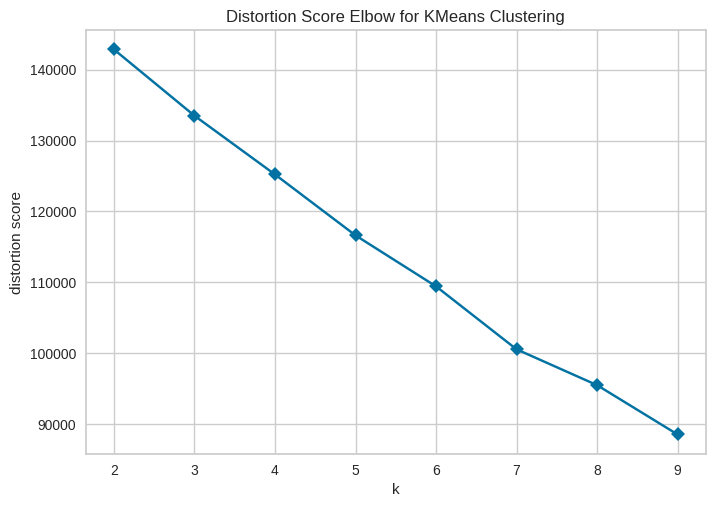

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
# 5pts
# Code for creating the elbow plot
model = KMeans(random_state = 9)
visualizer = KElbowVisualizer(model, k = (2, 10),locate_elbow=True, timings = False)
visualizer.fit(X)
visualizer.show()

**Written answer (2 pts): No, by the elbow plot, we cannot find the optimal number of clusters.**

2. Try between 2 and 6 clusters, using a seed of 9, and draw the silouhette plot for the K-means analysis. Report the silhouette scores. Do NOT use the built-in function `SilhouetteVisualizer()`.

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 2 The average silhouette_score is : 0.1317


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 3 The average silhouette_score is : 0.1422


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 4 The average silhouette_score is : 0.1529


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 5 The average silhouette_score is : 0.1431


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 6 The average silhouette_score is : 0.1491


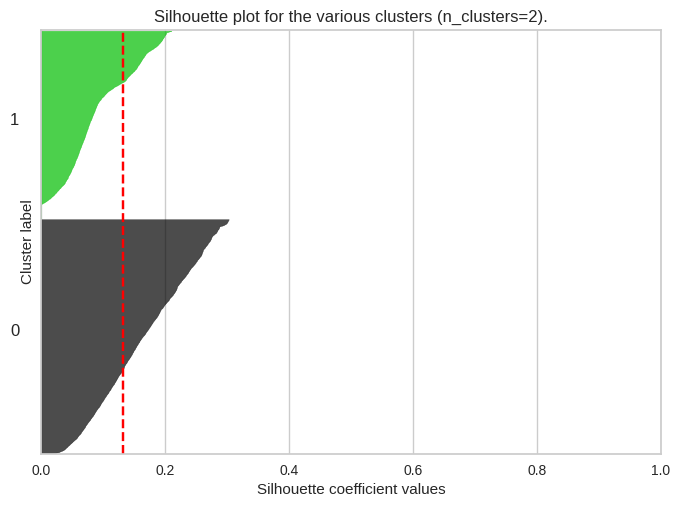

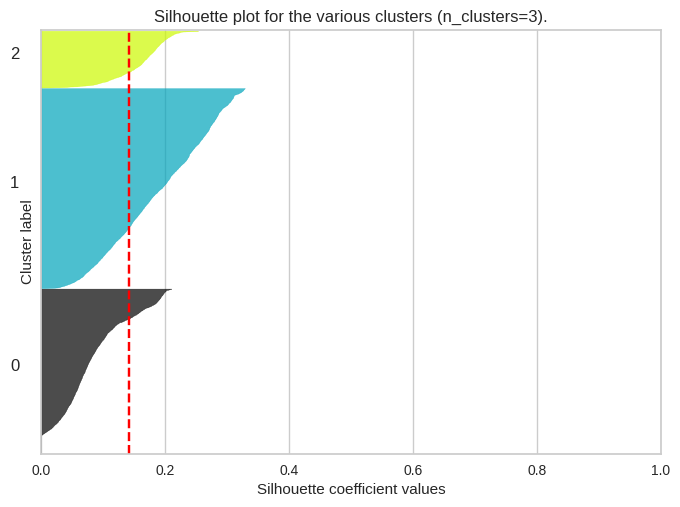

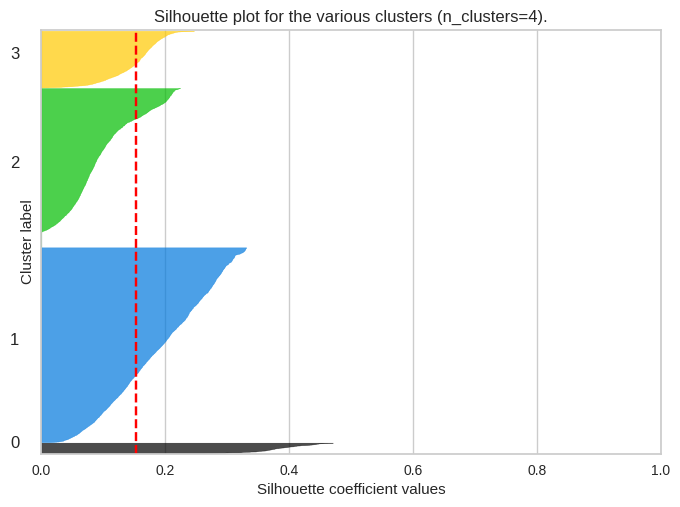

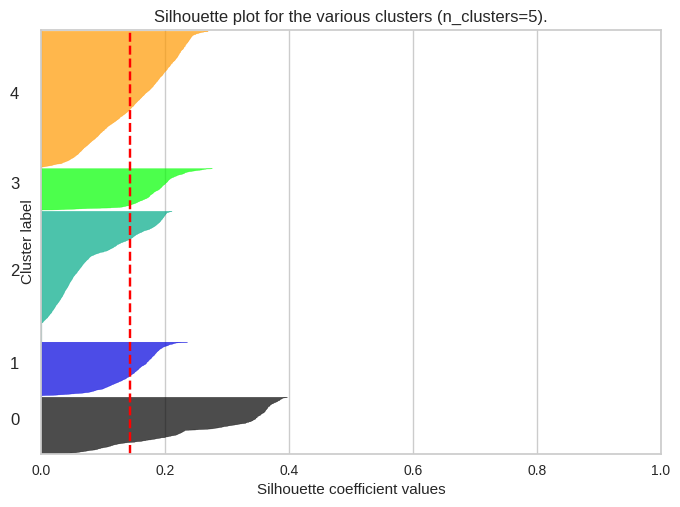

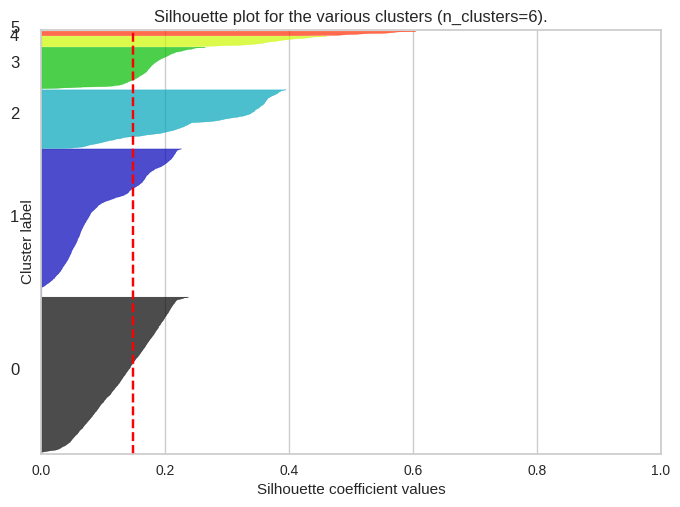

In [ ]:
# 16pts
range_n_clusters = [2, 3, 4, 5, 6]
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 1 columns
    fig, ax1 = plt.subplots(1, 1)

    # The 1st subplot is the silhouette plot
    ax1.set_xlim([0, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=9)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is : %.4f"  % silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    # Iterate over the clusters
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Silhouette plot for the various clusters (n_clusters=%i)." % (n_clusters))
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

**What is the optimal number of clusters using the silhouette method?**

**ANSWER HERE (2pts):** In this case the selection is for 5 (or 3) clusters, although the average silhouette score is not the maximum, the areas in Silhouette plot for each cluster have similar width, .

3. Use the first and second principle components of the data as the x and y axis, draw the scatter plot where points are differentiated by clusters. Hints: you need to first perform dimension reduction with PCA using 2 components.

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


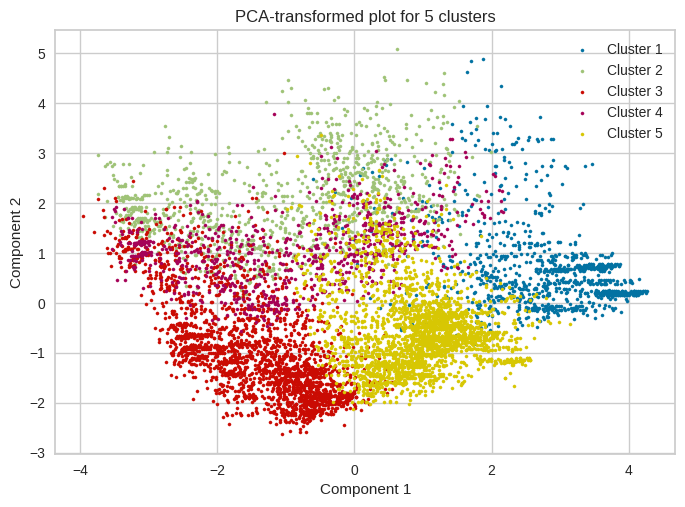

In [ ]:
# 13pts
# Calculate PCA
PCA_transformer = PCA(2)
PCA_data = PCA_transformer.fit_transform(X)

# For five clusters.
n_clusters = 5
clusterer = KMeans(n_clusters=n_clusters, random_state=9)
cluster_labels = clusterer.fit_predict(X)

# Plot!
for i in range(n_clusters):
    color = cm.nipy_spectral(float(i) / n_clusters)
    plt.scatter(PCA_data[cluster_labels==i, 0], PCA_data[cluster_labels==i, 1], 
                label='Cluster %i' % (i+1),s=5)

plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('PCA-transformed plot for %i clusters' % n_clusters)
plt.legend()


4. The objective of any cluster analysis over customer data is to create a reasonable segmentation of your customers. Using the number of clusters you have decided in Question 2.2, create a table of the averages per variable (`Age`, `Work_Experience`, `Family_Size`) of each cluster (use the original, non-scaled, variables). Conclude the characteristics of each cluster.

In [ ]:
#5pts
# For 5 clusters.
clusterer = KMeans(n_clusters=5, random_state=9)
df['KMeans_Clusters'] = clusterer.fit_predict(X)


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
# Crosstab with the averages per cluster
df.groupby(['KMeans_Clusters'])['Age','Work_Experience','Family_Size'].mean()


<ipython-input-12-ffc6e22eba84>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby(['KMeans_Clusters'])['Age','Work_Experience','Family_Size'].mean()


,Age,Work_Experience,Family_Size
KMeans_Clusters,,,
0,59.738689,1.902124,2.903047
1,38.260496,2.197519,3.479008
2,32.012395,3.043183,2.902839
3,38.817058,2.368356,2.901112
4,51.172821,2.307575,2.530643


**ANSWER HERE (2pts):** Group 0: old people (age around 59) with less work experience and middle family size(around 3). Group 4: old people (age around 51) with more work experience and smaller family size(around 2.5). Group 1: middle-age people (age around 38) with larger family size(around 3.5). Group 3: middle-age people (age around 38) with middle family size(around 3). Group 2: young people (age around 32).

## Question 3: Second Strategy (45 pts) 

1. First performing dimension reduction with PCA using 4 components. Look for the best number of clusters (between 3 to 6) using `Agglomerative clustering` with `affinity = 'cosine'` and `linkage = 'average'` and Silhuoette analysis.

In [ ]:
# 8 pts (PCA +  Silhuoette analysis)
df_strategy_1 = X.copy()
# Create the new data frame with principal components 
PCA_transform = PCA(4,random_state=9)
PCA_s4 = PCA_transform.fit_transform(df_strategy_1)

For n_clusters = 3 The average silhouette_score is : 0.2460
For n_clusters = 4 The average silhouette_score is : 0.2600
For n_clusters = 5 The average silhouette_score is : 0.2420
For n_clusters = 6 The average silhouette_score is : 0.2285


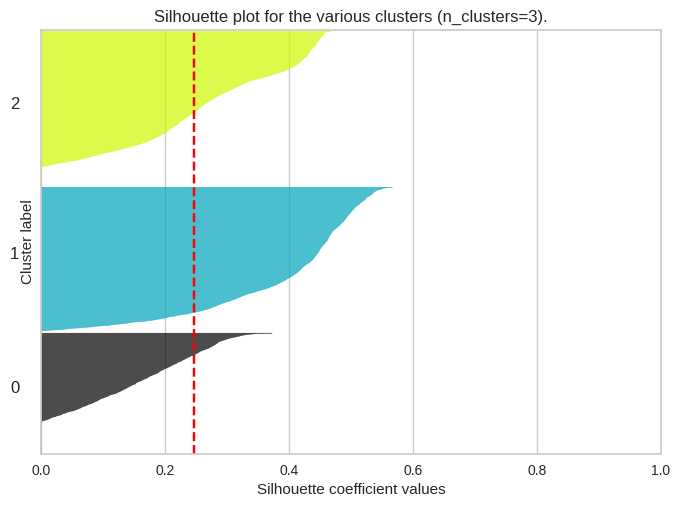

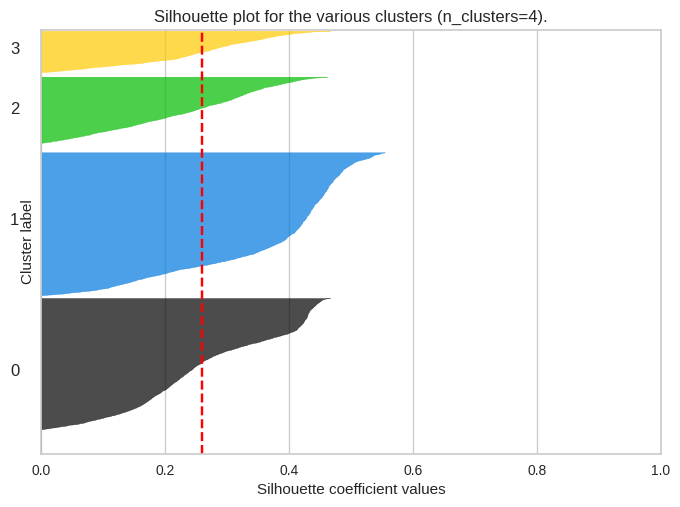

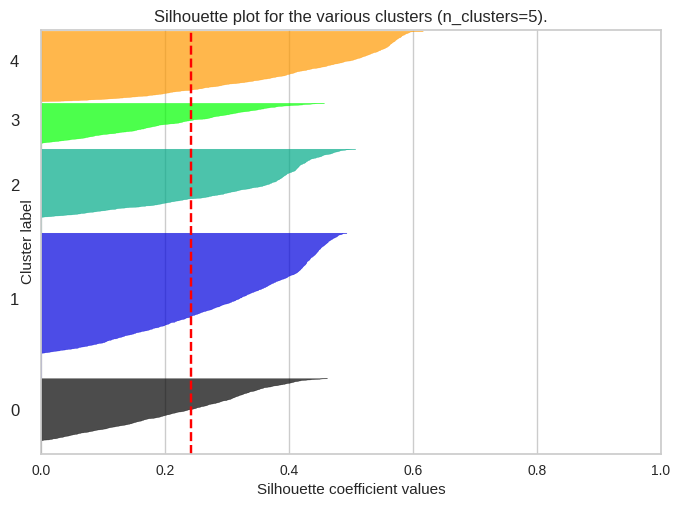

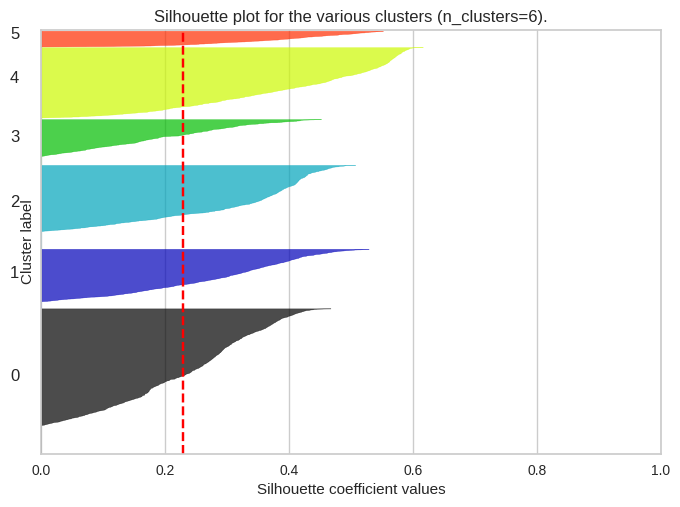

In [ ]:
# 15 pts 
# Range for the number of clusters
range_n_clusters = [3, 4, 5, 6]

for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, ax1 = plt.subplots(1, 1)

        # The 1st subplot is the silhouette plot
        ax1.set_xlim([0, 1])
        # The (n_clusters + 1) * 10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(PCA_s4) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value 
        clusterer = AgglomerativeClustering(n_clusters = n_clusters, # Number of clusters
                                         metric = 'cosine', # Type of distance.
                                                              # Depends on your data and you can create your own!
                                         linkage = "average" # Type of linkage.
                                        )
        
        cluster_labels = clusterer.fit_predict(PCA_s4)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed clusters
        silhouette_avg = silhouette_score(PCA_s4, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is : %.4f"  % silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(PCA_s4, cluster_labels)

        y_lower = 10

        # Iterate over the clusters
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor = color, edgecolor = color, alpha = 0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("Silhouette plot for the various clusters (n_clusters=%i)." % (n_clusters))
        ax1.set_xlabel("Silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x = silhouette_avg, color = "red", linestyle = "--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

**Written Answer:** How many clusters is select based on the previous results?

**ANSWER HERE (2pts):** In this case the selection is for 4 clusters, although the areas in Silhouette plot for each cluster do not have similar width, the average silhouette score is the maximum.

2. Graph the scatter plot of the PCA-transformed data differentiated by cluster. Use the first and second principle components of the data as the x and y axis.


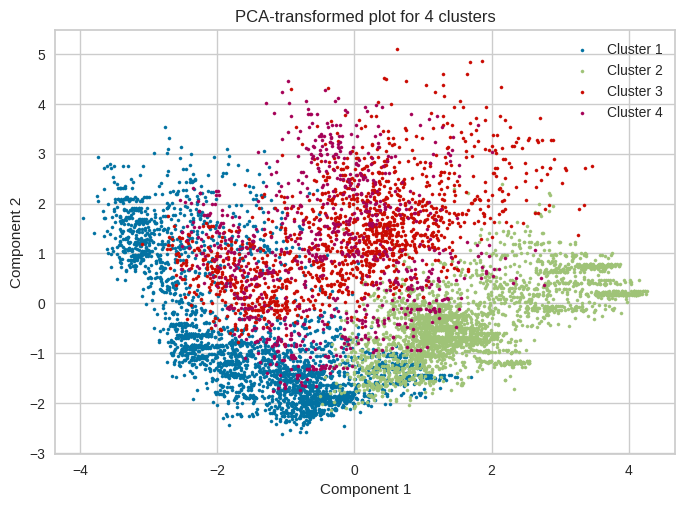

In [ ]:
# 8 pts
n_clusters = 4
clusterer = AgglomerativeClustering(n_clusters = n_clusters, # Number of clusters
                                    metric = 'cosine', # Type of distance.
                                                         # Depends on your data and you can create your own!
                                    linkage = "average" # Type of linkage.
                                        )
cluster_labels_s4 = clusterer.fit_predict(PCA_s4)
%matplotlib inline

for i in range(n_clusters):
    color = cm.nipy_spectral(float(i) / n_clusters)
    plt.scatter(PCA_s4[cluster_labels_s4 == i, 0], PCA_s4[cluster_labels_s4 == i, 1], label = 'Cluster %i' % (i + 1),s=5)

plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('PCA-transformed plot for %i clusters' % n_clusters)
plt.legend()

3. Make the boxplot `Age` vs `Family_Size` based on the dataFrame before standardization, and use `hue = "Your_Cluster_Label"` in the plot function to show the differences among clusters.

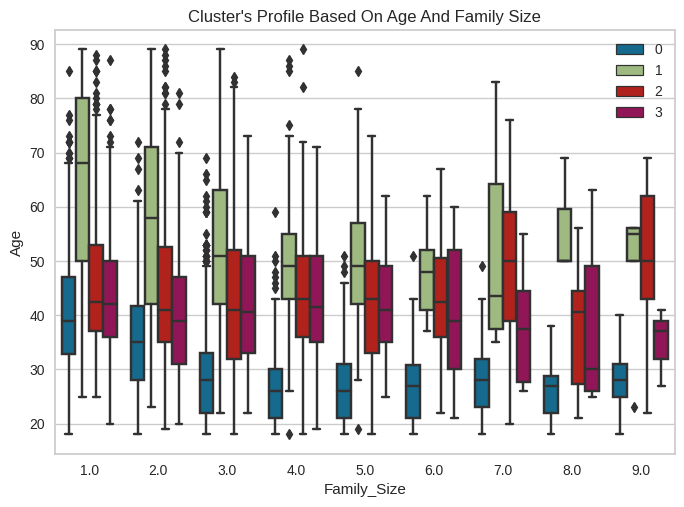

In [ ]:
# 7 pts
# boxplot
dataOHE['Cluster_Label'] = cluster_labels_s4
data = dataOHE
pl = sns.boxplot(y = data["Age"], x = data["Family_Size"], hue = data["Cluster_Label"])
pl.set_title("Cluster's Profile Based On Age And Family Size")
plt.legend()
plt.show()

4. Using the number of clusters you have decided in Question 3.1, create a table of the averages per variable (`Age`, `Work_Experience`, `Family_Size`) of each cluster (use the original, non-scaled, variables). Conclude the characteristics of each cluster.

In [ ]:
# 3pts
# For 5 clusters.
data.groupby(['Cluster_Label'])['Age','Work_Experience','Family_Size'].mean()

<ipython-input-24-d6accf22f7cc>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data.groupby(['Cluster_Label'])['Age','Work_Experience','Family_Size'].mean()


,Age,Work_Experience,Family_Size
Cluster_Label,,,
0,31.935798,2.953950,3.075630
1,55.765445,2.073994,2.627514
2,44.232801,2.208478,2.933287
3,42.275862,2.542529,2.711494


**ANSWER HERE (2pts):** Group 1: old people  with less work experience and small family size. Group 2: middle-age people with large family size(around 3) and less work experience. Group 3: middle-age people with more work experience. Group 0: young people with more work experience and small family size.
(Note that the conclusion might change, since we may get different results when running the same codes)

